In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Callable
import subprocess
import cv2
from io import BytesIO

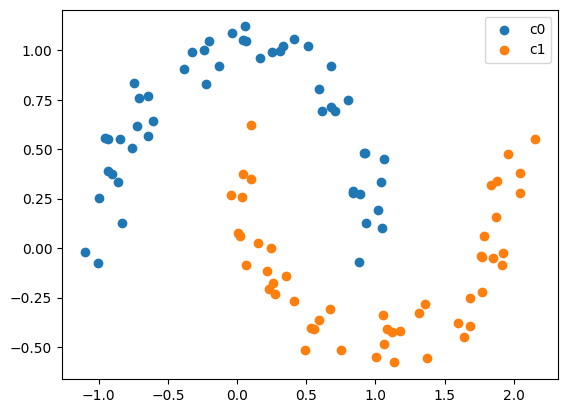

In [2]:
data = dict(np.load("two_moons.npz", allow_pickle=True))
samples = data["samples"]
labels = data["labels"]

c0_samples = samples[labels == 0]  # class 0: all samples with label 0
c1_samples = samples[labels == 1]  # class 1: all samples with labe 1

plt.figure("Data")
plt.scatter(x=c0_samples[:, 0], y=c0_samples[:, 1], label="c0")
plt.scatter(x=c1_samples[:, 0], y=c1_samples[:, 1], label="c1")
plt.legend()

In [3]:
def affine_features(x: np.ndarray) -> np.ndarray:
    """
    implements affine feature function
    :param x: inputs, shape: [N x sample_dim]
    :return inputs with additional bias dimension, shape: [N x feature_dim]
    """
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)

def quad_features(x: np.ndarray) -> np.ndarray:
    """
    implements quadratic feature function
    :param x: inputs, shape: [N x sample_dim]
    :return squared features of x, shape: [N x feature_dim]
    """
    sq = np.stack([x[:, 0] ** 2, x[:, 1]**2, x[:, 0] * x[:, 1]], axis=-1)
    return np.concatenate([sq, affine_features(x)], axis=-1)

def cubic_features(x: np.ndarray) -> np.ndarray:
    """
    implements cubic feature function
    :param x: inputs, shape: [N x sample_dim]
    :return cubic features of x, shape: [N x feature_dim]
    """
    cubic = np.stack([x[:, 0]**3, x[:, 0]**2 * x[:, 1], x[:, 0] * x[:, 1]**2, x[:, 1]**3], axis=-1)
    return np.concatenate([cubic, quad_features(x)], axis=-1)

def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    the sigmoid function
    :param x: inputs
    :return sigma(x)
    """
    return 1 / (1 + np.exp(-x))

def bernoulli_nll(predictions: np.ndarray, labels: np.ndarray, epsilon: float = 1e-12) -> np.ndarray:
    """
    :param predictions: output of the classifier, shape: [N]
    :param labels: true labels of the samples, shape: [N]
    :param epsilon: small offset to avoid numerical instabilities (i.e log(0))
    :return negative log-likelihood of the labels given the predictions
    """
    return - (labels * np.log(predictions + epsilon) + (1 - labels) * np.log(1 - predictions + epsilon))

In [4]:
def objective_bern(weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> float:
    """
    bernoulli log-likelihood objective
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape: [N]
    :return average negative log-likelihood
    """
    predictions = sigmoid(features @ weights)
    return np.mean(bernoulli_nll(predictions, labels))

def d_objective_bern(weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    gradient of the bernoulli log-likelihood objective
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape [N]
    """
    res = np.expand_dims(sigmoid(features @ weights) - labels, -1)
    grad = features.T @ res / res.shape[0]
    return np.squeeze(grad)

In [5]:
def minimize_with_sgd(features: np.ndarray, labels: np.ndarray, initial_weights: np.ndarray, schedule: Callable,
                      num_iterations: int, batch_size: int):
    """
    :param features: all samples, shape: [N x feature_dim]
    :param labels: all labels, shape: [N]
    :param initial_weights: initial weights of the classifier, shape: [feature_dim * K]
    :param schedule: learning rate schedule (a callable function returning the learning rate, given the iteration
    :param num_iterations: number of times to loop over the whole dataset
    :param batch_size: size of each batch, should be between 1 and size of data
    return "argmin", "min", logging info
    """

    assert 1 <= batch_size <= features.shape[0]
    # This is a somewhat simplifying assumption but for the exercise its ok
    assert features.shape[0] % batch_size == 0, "Batch Size does not evenly divide number of samples"
    batches_per_iter = int(features.shape[0] / batch_size)

    # setup
    weights = np.zeros([batches_per_iter * num_iterations + 1, initial_weights.shape[0]])
    loss = np.zeros(batches_per_iter * num_iterations + 1)
    weights[0] = initial_weights
    loss[0]= objective_bern(weights[0], features, labels)

    for i in range(num_iterations):
        # shuffle data / get random indices
        
        # sample random batches for current iteration
        rnd_idx = np.random.permutation(features.shape[0])
        for j in range(batches_per_iter):

            global_idx = i * batches_per_iter + j

            # stochastic gradient descent update!

            # get current batches
            sample_batch = features[rnd_idx[j * batch_size: (j + 1) * batch_size]]
            label_batch = labels[rnd_idx[j * batch_size: (j + 1) * batch_size]]

            # get learning rate and perform normal gradient descent step
            lr = schedule(global_idx)
            grad = d_objective_bern(weights[global_idx], sample_batch, label_batch)
            weights[global_idx + 1] = weights[global_idx] - lr * grad

            # log loss (on all samples, usually you should not use all samples to evaluate after each stochastic
            # update step)
            loss[global_idx + 1] = objective_bern(weights[global_idx + 1], features, labels)
    return weights[-1], loss[-1], (weights, loss)


In [6]:
plt_range = np.arange(-1.5, 2.5, 0.01)
plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

Final loss 0.28081789653651956


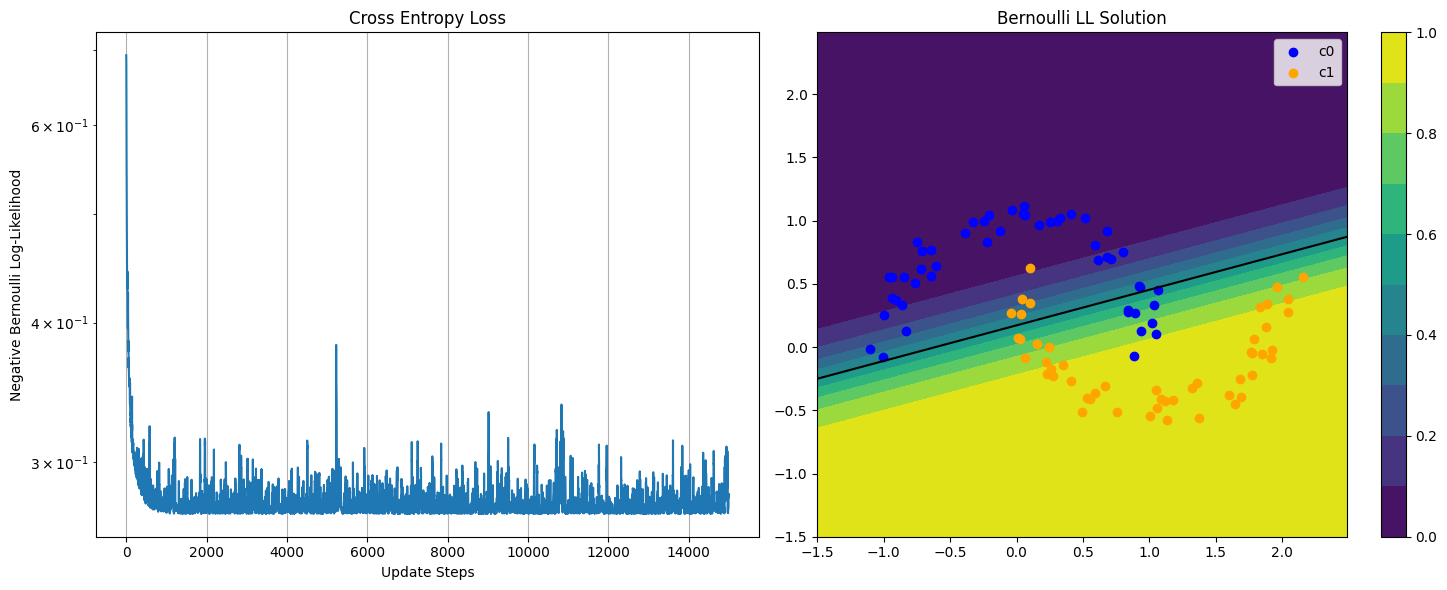

In [7]:
feature_fn = affine_features
# feature_fn = quad_features
# feature_fn = cubic_features
num_iterations = 150
        
features = feature_fn(samples)

w_bce, l, l_info = minimize_with_sgd(features, labels, np.zeros(features.shape[1]),
                                 schedule=(lambda t: 0.25),
                                 num_iterations=num_iterations,
                                 batch_size=1)
print("Final loss", l)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.set_title("Cross Entropy Loss")
ax1.grid(True)
ax1.set_xlabel("Update Steps")
ax1.set_ylabel("Negative Bernoulli Log-Likelihood")
ax1.semilogy(l_info[1])

ax2.set_title("Bernoulli LL Solution")
pred_grid = np.reshape(sigmoid(feature_fn(flat_plt_grid) @ w_bce), plt_grid_shape)

im = ax2.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
fig.colorbar(im, ax=ax2)
ax2.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[0, 0.5], colors=["k"])

s0 = ax2.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
s1 = ax2.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
ax2.legend([s0, s1], ["c0", "c1"])

plt.tight_layout()
plt.show(fig)

In [8]:
feature_functions = [affine_features, quad_features, cubic_features]
feature_names = ["affine", "quadratic", "cubic"]
iteration_ranges = [1 + 15 * x for x in range(20)]
plots = [[] for _ in range(len(feature_names))]

for j, (feature_fn, feature_name) in enumerate(zip(feature_functions, feature_names)):
    for i in range(len(iteration_ranges)):
        num_iterations = iteration_ranges[i]
        features = feature_fn(samples)
        
        w_bce, l, l_info = minimize_with_sgd(features, labels, np.zeros(features.shape[1]),
                                         schedule=(lambda t: 0.25),
                                         num_iterations=num_iterations,
                                         batch_size=1)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        ax1.set_title("Cross Entropy Loss")
        ax1.grid(True)
        ax1.set_xlabel("Update Steps")
        ax1.set_ylabel("Negative Bernoulli Log-Likelihood")
        ax1.semilogy(l_info[1])
        
        ax2.set_title("Bernoulli LL Solution")
        pred_grid = np.reshape(sigmoid(feature_fn(flat_plt_grid) @ w_bce), plt_grid_shape)
        
        im = ax2.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
        fig.colorbar(im, ax=ax2)
        ax2.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[0, 0.5], colors=["k"])
        
        s0 = ax2.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
        s1 = ax2.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
        ax2.legend([s0, s1], ["c0", "c1"])
        
        plt.tight_layout()

        # Save the plot as an image
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img = cv2.imdecode(np.frombuffer(buf.getvalue(), np.uint8), cv2.IMREAD_COLOR)
        plots[j].append(img)
        
        plt.close(fig)

In [9]:
def create_video_from_images(images, output_filename, fps=1):
    height, width, layers = images[0].shape
    process = subprocess.Popen([
        "ffmpeg",
        "-y",
        "-f", "image2pipe",
        "-vcodec", "png",
        "-framerate", str(fps),
        "-i", "-",
        "-c:v", "libx264",
        "-pix_fmt", "yuv420p",
        "-crf", "23",
        output_filename
    ], stdin=subprocess.PIPE, stderr=subprocess.DEVNULL)

    for image in images:
        _, buffer = cv2.imencode(".png", image)
        process.stdin.write(buffer.tobytes())

    process.stdin.close()
    process.wait()

for i, name in enumerate(feature_names):
    create_video_from_images(plots[i], f"{name}.mp4")